# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [16]:
import tensorflow as tf
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization

![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
# Run this cell to load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [15]:
# Load the training and testing data and labels from the dictionary
train_x, train_y, test_x, test_y = train['X'], train['y'], test['X'], test['y']
print(f'Training data shape: {train_x.shape}\n\
Training labels shape:{train_y.shape}\n\
Test data shape:{test_x.shape}\n\
Test labels shape:{test_y.shape}')

Training data shape: (32, 32, 3, 73257)
Training labels shape:(73257, 1)
Test data shape:(32, 32, 3, 26032)
Test labels shape:(26032, 1)


In [19]:
# Rearrange the train and test data to have number of examples 1st

train_x = np.moveaxis(train_x, -1, 0)
test_x = np.moveaxis(test_x, -1, 0)

# Print the shape of the data again
print(f'Training data shape: {train_x.shape}\n\
Training labels shape:{train_y.shape}\n\
Test data shape:{test_x.shape}\n\
Test labels shape:{test_y.shape}')

Training data shape: (73257, 32, 32, 3)
Training labels shape:(73257, 1)
Test data shape:(26032, 32, 32, 3)
Test labels shape:(26032, 1)


In [57]:
# Replace the class label 10 to 0
test_y[test_y==10] = 0
train_y[train_y==10] = 0

In [58]:
# Helper function to convert color images to gray and normalize it.
def color_to_normalized_gray(arr):
    """Convert array of colored images to gray and normalize it's values
       by dividing by 255.
       baram: arr: numpy array of shape(num_images, height, width, 3)
       return normailized array of gray images.
    """
    gray_images = np.mean(arr, 3, keepdims=True) / 255
    return gray_images

In [59]:
train_x_gray = color_to_normalized_gray(train_x)
test_x_gray = color_to_normalized_gray(test_x)
# Print the shape of the data again
print(f'New training data shape: {train_x_gray.shape}\n\
New est data shape:{test_x_gray.shape}\n')

New training data shape: (73257, 32, 32, 1)
New est data shape:(26032, 32, 32, 1)



In [60]:
def plot_images(images, nrows, ncols, true_labels, predictions=None):
    """ Helper function for plotting nrows * ncols images
        param: images: array of images to plot
        param: nrows: number of rows in the subplot
        param: ncols: number of columns in the subplot
        param: true_labels: true label values of the images
        param: predictions: predicted labels of the images
        return None
    """
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 2*nrows))
    for i, ax in enumerate(axes.flat): 
        if predictions is None:
            title = f"Label: {str(true_labels[i])}"
        else:
            title = f"Label: {str(true_labels[i])}, Pred: {str(predictions[i])}"
            
        if images[i].shape == (32, 32, 3):
            ax.imshow(images[i])
        else:
            ax.imshow(images[i,:,:,0], cmap="gray")
            
        ax.set_title(title)   
        ax.set_xticks([]); ax.set_yticks([])

Training Examples


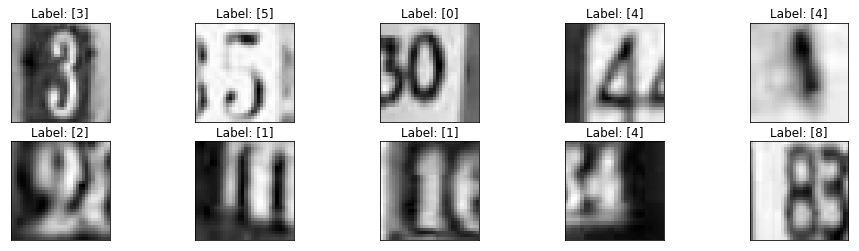

In [61]:
np.random.seed(0)
idx_train = np.random.choice(train_x_gray.shape[0]-1, 10)
print('Training Examples')
plot_images(train_x_gray[idx_train], 2, 5, train_y[idx_train])

Test Examples


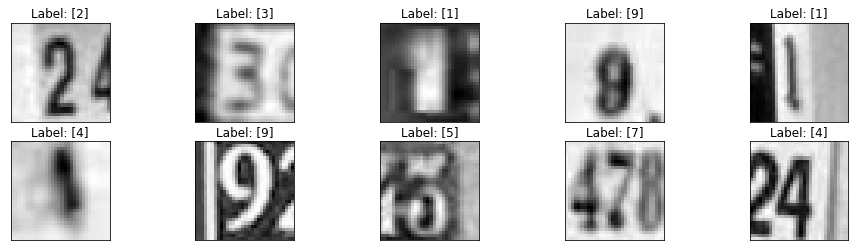

In [62]:
# get random indices for test
np.random.seed(0)
idx_test = np.random.choice(test_x_gray.shape[0]-1, 10)
print('Test Examples')
plot_images(train_x_gray[idx_test], 2, 5, train_y[idx_test])

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.